<a href="https://colab.research.google.com/github/ekity1002/DL4US_FINAL_WORK/blob/master/%E5%89%8D%E5%87%A6%E7%90%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Mecab のセットアップ

In [2]:
# mecab 
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl lib

In [3]:
# mecab-ipadic-NEologdのインストール
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 53 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.
[install-mecab-ipadic-NEologd] : Start..
[install-mecab-ipadic-NEologd] : Check the existance of libraries
[install-mecab-ipadic-NEologd] :     find => ok
[install-mecab-ipadic-NEologd] :     sort => ok
[install-mecab-ipadic-NEologd] :     head => ok
[install-mecab-ipadic-NEologd] :     cut => ok
[install-mecab-ipadic-NEologd] :     egrep => ok
[install-mecab-ipadic-NEologd] :     mecab => ok
[install-mecab-ipadic-NEologd] :     mecab-config => ok
[install-mecab-ipadic-NEologd] :     make => ok
[install-mecab-ipadic-NEologd] :     curl => ok
[install-mecab-ipadic-NEologd] :     sed => ok
[install-mecab-ipadic-NEologd] :     cat => ok
[install-mecab-ipadic-NEologd] :     diff => ok
[install-mecab-ipadic-NEologd] :   

In [0]:
import MeCab
import subprocess

cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
m=MeCab.Tagger("-d {0}".format(path))

## 画像展開

In [5]:
! mkdir train_img
! unzip "/content/drive/My Drive/Colab Notebooks/data/train_img.zip" -d train_img
! mkdir test_img
! unzip "/content/drive/My Drive/Colab Notebooks/data/test_img.zip" -d test_img

Archive:  /content/drive/My Drive/Colab Notebooks/data/train_img.zip
  inflating: train_img/img100.jpg    
  inflating: train_img/img101.jpg    
  inflating: train_img/img102.jpg    
  inflating: train_img/img103.jpg    
  inflating: train_img/img104.jpg    
  inflating: train_img/img105.jpg    
  inflating: train_img/img106.jpg    
  inflating: train_img/img107.jpg    
  inflating: train_img/img108.jpg    
  inflating: train_img/img109.jpg    
  inflating: train_img/img10.jpg     
  inflating: train_img/img110.jpg    
  inflating: train_img/img111.jpg    
  inflating: train_img/img112.jpg    
  inflating: train_img/img113.jpg    
  inflating: train_img/img114.jpg    
  inflating: train_img/img115.jpg    
  inflating: train_img/img116.jpg    
  inflating: train_img/img117.jpg    
  inflating: train_img/img118.jpg    
  inflating: train_img/img119.jpg    
  inflating: train_img/img11.jpg     
  inflating: train_img/img120.jpg    
  inflating: train_img/img121.jpg    
  inflating: train_

# 前処理

## 材料の前処理

In [0]:
# いらない文字を消す
import csv
import glob
import re
import pickle
from tqdm import tqdm

from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow.keras
from keras.preprocessing.text import Tokenizer

def clean_text(text):
    #replaced_text = '\n'.join(s.strip() for s in text.splitlines()[2:] if s != '')  # skip header by [2:]
    replaced_text = text.lower()
    replaced_text = re.sub(r'(<.*>|＜.*＞|\(.*\)|（.*）|\[.*\]|【.*】|［.*］|≪.*≫)', ' ', replaced_text) # カッコに囲まれた部分の除去
    replaced_text = re.sub(r'[a-zA-Zａｂｅｘ]', ' ', replaced_text)       # アルファベットの除去
    replaced_text = re.sub(r'[★☆✩○〇⚫︎◎●◇◆△▲▼▽※＊\*✲■□・\.♡⭐⚪♪]', ' ', replaced_text) # 記号除去
    replaced_text = re.sub(r'[＜＞<>]', ' ', replaced_text)       # の除去
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    return replaced_text

In [7]:
# 材料のテキスト前処理


def save_text_tokenizer(tokenizer, file_name):
  # saving
  with open(file_name+".pickle", 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_text_tokenizer(file_name):
  # loading
  with open(file_name+".pickle", 'rb') as handle:
      return pickle.load(handle)

def preprocess_ingredient_tsv(path):
    mecab = MeCab.Tagger ("-Owakati")
    with open(path, 'r') as f:
        texts = []
        for line in f:
            # ゴミの除去
            line = clean_text(line.strip())

            # 分かち書き
            text = mecab.parse(line)
            texts.append(text)

        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(texts)

        # 文書吸う
        print(tokenizer.document_count)

        # 単語分布確認
        print(tokenizer.word_counts)

        # 単語の正規化する単語決め、正規化

        # ストップワード除去

        # ベクトル化

        # ベクトル化 npy (y_train, y_test)保存
        # [1, 234, 34, ...] 単語ID のベクトルのリスト
        return tokenizer
train_tokenizer = preprocess_ingredient_tsv('/content/drive/My Drive/Colab Notebooks/data/ZAIRYOU.tsv')
save_text_tokenizer(train_tokenizer, '/content/drive/My Drive/Colab Notebooks/data/train_tokenizer')
test_tokenizer = preprocess_ingredient_tsv('/content/drive/My Drive/Colab Notebooks/data/test_ZAIRYOU.tsv')
save_text_tokenizer(test_tokenizer, '/content/drive/My Drive/Colab Notebooks/data/test_tokenizer')

720
OrderedDict([('長芋', 7), ('エリンギ', 8), ('シメジ', 1), ('パセリ', 24), ('バター', 46), ('醤油', 185), ('塩', 299), ('コショウ', 59), ('むき', 6), ('えび', 12), ('オリーブ', 91), ('オイル', 92), ('にんにく', 91), ('チューブ', 29), ('白', 49), ('ワイン', 19), ('ブラックペッパー', 18), ('しいたけ', 12), ('とろける', 22), ('チーズ', 70), ('白菜', 17), ('だ', 18), ('し', 37), ('さとう', 4), ('おろし', 43), ('ニンニク', 26), ('きざみ', 3), ('昆布', 16), ('ベーコン', 16), ('じゃがいも', 18), ('粗', 18), ('びき', 8), ('黒', 45), ('こしょう', 46), ('ドライ', 6), ('牡蠣', 14), ('ミニ', 9), ('トマト', 28), ('マッシュルーム', 12), ('国産', 2), ('レモン', 36), ('ピンクペッパー', 3), ('イタリアン', 6), ('山芋', 2), ('しょうゆ', 65), ('ぶ', 6), ('な', 9), ('しめじ', 22), ('味噌', 54), ('マヨネーズ', 41), ('薄', 1), ('揚げ', 19), ('酒', 235), ('、', 132), ('砂糖', 165), ('ネギ', 24), ('小口切り', 12), ('クレージーソルト', 1), ('みりん', 121), ('サラダ油', 52), ('乾燥', 8), ('片栗粉', 56), ('鶏', 54), ('手羽', 15), ('元', 3), ('しょう油', 13), ('しょうが', 32), ('生姜', 60), ('胸', 9), ('肉', 54), ('小麦粉', 44), ('スライス', 17), ('マジックソルト', 4), ('挽き', 14), ('胡椒', 62), ('牛乳', 20), ('ピザ', 15), ('用',

## 画像の前処理

In [22]:
def preprocess_image(img_txt, img_dir, img_size):
    # npz 形式に保存
    imgs = np.zeros((1,224,224,3))
    with open(img_txt, 'r') as f:
        for i, line in tqdm(enumerate(f)):
            img_name = line.strip()
            if not img_name:
                continue

            # リサイズして読み込み
            img = np.asarray(Image.open(img_dir+'/'+img_name).resize(img_size)).reshape(1, 224,224,3)
            if i==0:
                imgs[0] = img
            else:
                imgs = np.vstack([imgs, img])
    print(imgs.shape)
    return imgs
imgs = preprocess_image('/content/drive/My Drive/Colab Notebooks/data/IMG_PATH.tsv', 'train_img', (224,224))
np.save('/content/drive/My Drive/Colab Notebooks/data/train_img.npy', imgs)
imgs = preprocess_image('/content/drive/My Drive/Colab Notebooks/data/test_IMG_PATH.tsv', 'test_img', (224,224))
np.save('/content/drive/My Drive/Colab Notebooks/data/test_img.npy', imgs)

720it [01:28,  4.12it/s]


(720, 224, 224, 3)


240it [00:10, 12.01it/s]


(240, 224, 224, 3)


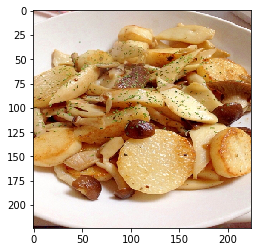

In [25]:
# img確認
train_imgs = np.load('/content/drive/My Drive/Colab Notebooks/data/train_img.npy')
plt.imshow(train_imgs[0]/255.0)